In [2]:

from numpy import *

from calc_catenary_from_ext_points import *

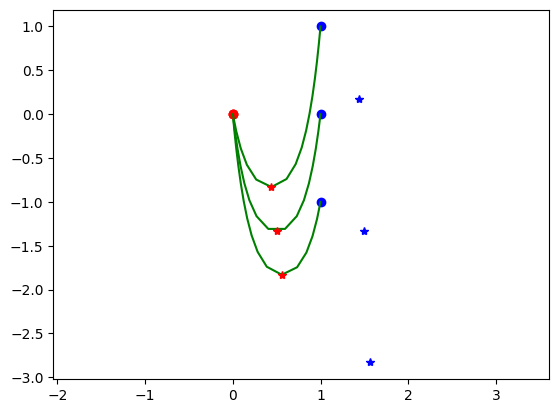

In [26]:
A = [ 0, 0, 0 ]
B = [ 1, 0, 1 ]

for d in linspace( -1, 1, 3 ):
	B[ 2 ] = d
	P, _, D, H = get_coor_marker_points_ideal_catenary( *A, *B, 3, .2 )
	plt.plot( *(A[ ::2 ]), 'ro' )
	plt.plot( *(B[ ::2 ]), 'bo' )
	plt.plot( P[ :, 0 ], P[ :, 2 ], 'g-' )
	
	L0 = [A[0] + D, A[2] - H]
	L1 = [B[0] + D, B[2] - H]
	plt.plot(*L0, 'r*')
	plt.plot(*L1, 'b*')
plt.axis( 'equal' )
plt.show()